In [51]:
import numpy as np
import sys
import os

# Import Experiment class from FGPGM
fgpgm_root = "/home/dsemchin/Progression_models_simulations/FGPGM-master/FGPGM"
sys.path.append(fgpgm_root)
from Experiment import Experiment

import numpy as np
import matplotlib.pyplot as plt

class MultiBiomarkerLogistic(Experiment):
    def __init__(self, n_biomarkers=5):
        self.n_biomarkers = n_biomarkers
    
    def f(self, x, theta):
        """
        dx/dt = (I - diag(x)) @ (K @ x + f)
        """
        n = self.n_biomarkers
        f = theta[:n]  # First `n` elements are forcing terms

        # Reconstruct adjacency matrix K from theta
        K = np.zeros((n, n))
        upper_diag = theta[n:]  # Next `n-1` elements are the first off-diagonal
        for i in range(n - 1):
            K[i, i + 1] = upper_diag[i]
            K[i + 1, i] = upper_diag[i]  # Ensure symmetry

        # Compute dx/dt
        dx_dt = np.dot(np.eye(n) - np.diag(x), np.dot(K, x) + f)
        return dx_dt

    def getBounds(self, nStates, nParams, x0=None):
        """
        Returns bounds for states and parameters to constrain optimization.

        States (x) are between [0, 1].
        Forcing terms (f) can be small positive values.
        Connectivity (K elements) can be between [0, 2] since they're just 1s initially.

        Parameters:
        - nStates: Number of state variables
        - nParams: Number of parameters

        Returns:
        - xmin, xmax: Lists of lower and upper bounds
        """
        xmin = []
        xmax = []

        # Bounds for biomarker states
        for _ in range(nStates):
            xmin.append(0)
            xmax.append(1)

        # Bounds for forcing terms
        for _ in range(nStates):
            xmin.append(0)
            xmax.append(0.1)

        # Bounds for connectivity matrix off-diagonal elements
        for _ in range(nStates - 1):
            xmin.append(0)
            xmax.append(1) 

        return xmin, xmax


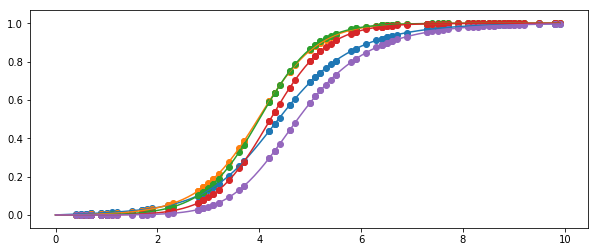

In [52]:
np.random.seed(1)
n_biomarkers = 5
obsStd = 0.1  # noise

# initial conditions
XInit = np.zeros(n_biomarkers)
forcing_terms = np.zeros(n_biomarkers)
forcing_terms[0] = 0.01  # Small forcing for first biomarker
connectivity_offdiag = np.ones(n_biomarkers - 1)  # Off-diagonal connectivity
theta = np.concatenate([forcing_terms, connectivity_offdiag])  # Parameter vector

# time parameters
t_max = 10
dt = 0.1
time = np.arange(0, t_max, dt)

experiment = MultiBiomarkerLogistic(n_biomarkers=n_biomarkers)

# simulate trajectory
x_true, y = experiment.sampleTrajectoryNonUniform(
    XInit,
    theta,
    time,
    obsNoiseStd=obsStd,
    SNR=None,
    plotting=None
)


if x_true.shape[0] != n_biomarkers:
    x_true = x_true.T

# generate patietns
n_obs = 100
obs_indices = np.random.choice(len(time), size=n_obs, replace=True)
obs_indices.sort()
t_obs = time[obs_indices]
x_obs = x_true[:, obs_indices] 

plt.figure(figsize=(10, 4))
for i in range(n_biomarkers):
    plt.plot(time, x_true[i])
    plt.scatter(t_obs, x_obs[i])
plt.show()


In [56]:
import sys
import os

sys.path.append('/home/dsemchin/Progression_models_simulations/FGPGM-master')
os.chdir('/home/dsemchin/Progression_models_simulations/FGPGM-master')

from FGPGM.Kernels.RBF import RBF
from FGPGM.DensityCalculation import getAs, getDs, getLambdaStars, calculateLogDensity
import numpy as np
import matplotlib.pyplot as plt

plt.switch_backend('agg')

standardize = True

"""kernel optimization """
# amount of basinhopping iterations in kernel hyperparameter optimization
kernelIter = 5  # should be adjusted based on roughness of likelihood
gammaValue = 3e-1

# print("time.shape:", time.shape)
# print("y.shape:", y.shape)

time = np.asarray(time).flatten()
if y.shape[0] != n_biomarkers:
    y = y.T

# print("time.shape after reshape:", time.shape)
# print("y.shape after reshape:", y.shape)

"""create Kernel and Kernel matrices"""

best_theta = []
best_sigma = []

for i in range(n_biomarkers):
    kernel = RBF(theta=np.abs(np.random.randn(2)),
                 sigma=np.abs(np.random.randn(1)))

    print("optimizing hyperparameters for biomarker", i + 1)

    kernel.learnHyperparams(
        kernel.theta,
        kernel.sigma,
        y[i, :],  # Use data from the i-th biomarker
        time,
        normalize=True,
        standardize=standardize,
        newNugget=1e-4,
        anneal=False,
        basinIter=kernelIter
    )

    print("optimal hyperparameters for biomarker", i + 1)
    print("gammaValue: ", gammaValue)
    print("theta: ", kernel.theta)
    print("sigma: ", kernel.sigma)

    best_theta.append(kernel.theta)
    best_sigma.append(kernel.sigma)

best_theta = np.array(best_theta)
best_sigma = np.array(best_sigma)


('optimizing hyperparameters for biomarker', 1)
using L-BFGS-B as hyperparameter optimizer
YES: -1.8622074684 @ [0.79389706 2.27044803 0.20588801]
YES: -1.86220746843 @ [0.79389654 2.27043386 0.20588768]
YES: -1.86220746841 @ [0.79391296 2.27044589 0.20588761]
YES: -1.86220746843 @ [0.79390072 2.27043264 0.20588765]
YES: -1.86220746843 @ [0.79390482 2.27043438 0.20588762]
Kernel optimization output: 
                        fun: -1.8622074684290748
 lowest_optimization_result:       fun: -1.8622074684290748
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.21884749e-07, 2.44249065e-07, 1.77635684e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 124
      nit: 25
   status: 0
  success: True
        x: array([0.79390072, 2.27043264, 0.20588765])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 776
                        n

In [66]:
print(time.shape)
print(y.shape)

test_kernel = kernel(theta=best_theta, sigma=best_sigma)
val = test_kernel.k(time[0], time[1])  
print("Kernel output:", val)
print("Kernel output type:", type(val))
print("Kernel output shape:", np.shape(val))  # Should be ()

print("best_theta shape:", np.shape(best_theta))
print("best_sigma shape:", np.shape(best_sigma))

(100,)
(5, 100)
('Kernel output:', array([0.78868453, 2.26875287]))
('Kernel output type:', <type 'numpy.ndarray'>)
('Kernel output shape:', (2,))
('best_theta shape:', (5, 2))
('best_sigma shape:', (5,))


In [77]:
# -*- coding: utf-8 -*-
# Author: Philippe Wenk <philippewenk@hotmail.com>
"""
After experiments have been created using the script createExperiments.py,
this script can be run to infer the ODE parameters using FGPGM.
"""
import numpy as np

from FGPGM.Kernels.RBF import RBF as kernel
from FGPGM.FGPGM import FGPGM

from matplotlib import pyplot as plt
plt.switch_backend('agg')

"""determine standardization"""
if standardize == 0:
    standardize=False
    print("Do not use standardization of the observations")
elif standardize == 1:
    standardize=True
    print("Use standardization of the observations")
else:
    raise ValueError("Illegal value encountered in standardize.csv." +
                     "Maybe the file is corrupted?")

"""experiment and observation loading"""

# create experiment
experiment = MultiBiomarkerLogistic(n_biomarkers=n_biomarkers)
gammas = gammaValue*np.ones(y.shape[1])

"""create kernels using hyperparameters calculated by getHyperparams.py"""
kernels = []
for state in np.arange(y.shape[0]):
    currentKernel = kernel(theta=best_theta[state], sigma=best_sigma[state])  # ✅ FIXED
    kernels.append(currentKernel)

"""find initial values for theta"""
trueTheta = theta
theta0 = np.abs(np.random.randn(trueTheta.size))    

"""create FGPGM object"""
FM = FGPGM(kernels=kernels,
           time=time,
           y=y.T,
           experiment=experiment,
           nODEParams=trueTheta.size,
           gamma=gammas,
           normalize=True,
           standardize=standardize)

"""perform actual parameter estimation minimization"""
stateStds = np.ones(y.size)*0.075
paramStds = np.ones(theta0.size)*0.09
propStds = np.concatenate([stateStds, paramStds])

newStates, newParams = FM.getFGPGMResults(GPPosteriorInit=True,
                                          blockNegStates=False,
                                          debug=True,
                                          theta0=theta0,
                                          thetaMagnitudes=np.zeros_like(theta0),
                                          nSamples=3000,
                                          nBurnin=1000,
                                          propStds=propStds)

print(newParams)

# np.savetxt("optimalParamsFGPGM.csv", newParams)
# np.savetxt("optimalStatesFGPGM.csv", newStates)
# print(newParams)

"""Visualizing the results"""
tEnd = time[-1]
timeDense = np.linspace(0, tEnd, 500)
XInit = y[0, :]  # Use first observed values as initial conditions

xDenseTrue = experiment.sampleTrajectoryNonUniform(XInit, trueTheta, timeDense, obsStd)[0]
xDenseNew = experiment.sampleTrajectoryNonUniform(XInit, newParams, timeDense, obsStd)[0]

plt.figure(figsize=(10, 5))
for i in range(xDenseNew.shape[1]):
    plt.plot(timeDense, xDenseTrue[:, i], 'k', linestyle="dashed")
    plt.plot(timeDense, xDenseNew[:, i], 'r')
    plt.scatter(time, newStates[:, i], marker='x', c='b')
    plt.xlabel("time")
    plt.ylabel("population")
    plt.legend(["truth", "fit", "obs"])
    plt.show()


Use standardization of the observations
initialize with GP posterior
x0[70] too big
x0[71] too big
x0[72] too big
x0[73] too big
x0[74] too big
x0[75] too big
x0[76] too big
x0[77] too big
x0[78] too big
x0[79] too big
x0[80] too big
x0[81] too big
x0[387] too big
x0[388] too big
x0[389] too big
x0[390] too big
x0[391] too big
x0[392] too big
x0[393] too big
x0[394] too big
x0[395] too big
x0[396] too big
x0[397] too big
x0[398] too big
x0[469] too big
x0[470] too big
x0[471] too big
x0[472] too big
x0[473] too big
x0[474] too big
x0[475] too big
x0[476] too big
x0[477] too big
x0[478] too big
x0[479] too big
x0[480] too big
x0[481] too big
x0[482] too big
x0[483] too big
x0[484] too big
x0[485] too big
x0[486] too big
x0[487] too big
x0[488] too big
x0[489] too big
x0[490] too big
x0[491] too big
x0[492] too big
x0[493] too big
x0[494] too big
x0[495] too big
x0[496] too big
x0[497] too big
x0[498] too big
x0[500] too big
x0[501] too big
x0[502] too big
x0[503] too big
x0[504] too big

AssertionError: 

In [74]:
print(y.shape)

(5, 100)


In [ ]:
print(time.shape)
print(y.shape)

test_kernel = kernel(theta=best_theta, sigma=best_sigma)
val = test_kernel.k(time[0], time[1])  
print("Kernel output:", val)
print("Kernel output type:", type(val))
print("Kernel output shape:", np.shape(val))  # Should be ()

print("best_theta shape:", np.shape(best_theta))
print("best_sigma shape:", np.shape(best_sigma))

(100,)
(5, 100)
('Kernel output:', array([0.78868453, 2.26875287]))
('Kernel output type:', <type 'numpy.ndarray'>)
('Kernel output shape:', (2,))
('best_theta shape:', (5, 2))
('best_sigma shape:', (5,))
